In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import tensorflow as tf

!pip install np_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Opdracht/music_genre.csv")
df.columns

# Random seed for reproducibility
seed = 10
np.random.seed(seed)

# Preprocessing the data

Before we can get to work testing models we have to clean up our data by dropping irrelevant columns and transforming the non-numerical ones.<br />
First let's remove the columns we will not need and find out which columns are non numerical. 

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

df = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Opdracht/music_genre.csv")

# Silently remove the 4 rows with all nan values
df = df.dropna(how='all')

# First let's do something about the tempo which is just non numerical because NaN values are instead given the value '?'
df.tempo = df.tempo.replace('?', np.NaN).astype('float64')

# Same for the '-1' values in duration_ms:
df.duration_ms = df.duration_ms.replace(-1.0, np.nan)

# Remove non significant columns
X = df.copy().drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis=1)

# Select target prediction data
y = X.pop('music_genre')

s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)


Categorical variables:
['key', 'mode']


Next let's do something about the 'mode' column. This column only contains values 'Minor' and 'Major'. We can simply replace those by 0 and 1 to create a binary map that the models can use:

In [3]:
df = df.replace('Minor', 0)
df = df.replace('Major', 1)

Now we are still left with two columns that have non numerical values. Key can be any letter A-G with or without a hashtag, this corresponds with 12 possible values (B and E only occur without the hashtag). Genre is the column we are trying to predict, it contains one of 10 genres. We now have to choose between ordinal encoding or one-hot encoding for these columns. Ordinal column may be meaningful for key but for genre this seems to be less logical.

In [4]:
from sklearn.preprocessing import LabelEncoder

key_encoder = LabelEncoder()
df.key = key_encoder.fit_transform(df.key)

genre_encoder = LabelEncoder()
df.music_genre = genre_encoder.fit_transform(df.music_genre)

df2 = df.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis=1).dropna()

# Defining preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), ['popularity','acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence']),
)

# Remove non significant columns
X = df2.copy()

# Select target prediction data
Y = X.pop('music_genre')

print(df.groupby(Y).size())

#s = (X_train.dtypes == 'object')
#object_cols = list(s[s].index)

#print("Categorical variables:")
#print(object_cols)

music_genre
0.0    4051
1.0    4064
2.0    4046
3.0    4036
4.0    4049
5.0    4032
6.0    4077
7.0    4064
8.0    4042
9.0    4099
dtype: int64


All genres have more or less the same sample size so we will assume there is no imbalance.

In [5]:
# Normalize features within range 0 (minimum) and 1 (maximum)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

# Convert target Y to one hot encoded Y for Neural Network
encoder = LabelEncoder()
encoder.fit(Y)
Y_pre = encoder.transform(Y)
Y = to_categorical(Y_pre)

# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X.values

# Finding the right model

We prepare for our search by writing a function that will help us decide which models and features perform best. We chose to base our scoring on the model.evaluate function.


In [6]:
import time

# a function to test our features and models against each other
def test_model(model):
    start_time = time.time()
    # Create Keras Classifier and use predefined baseline model
    estimator = KerasClassifier(build_fn = model, epochs = 100, batch_size = 128, verbose = 0)
    # Try different values for epoch and batch size

    # KFold Cross Validation
    kfold = KFold(n_splits = 5, shuffle = True, random_state = seed)
    # 5 splits as to always have +- 8500 entries

    # Object to describe the result
    results = cross_val_score(estimator, X, Y, cv = kfold, n_jobs=-1)
    # Result
    print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    print("time elapsed: %s seconds" % (time.time() - start_time))
    return results

## Attempt 2: Keras Classifier
First let's setup our neural network with just one layer. We will try and find out which (hidden) activation layer works best as our final activation. (Through experimenting we found that the final activation layer is usually different from the other activation layers, and it is the most important one)

--- softmax ---
Result: 51.21% (0.55%)
time elapsed: 22.431068897247314 seconds
--------------------------
--- relu ---
Result: 28.55% (15.23%)
time elapsed: 23.455528259277344 seconds
--------------------------
--- sigmoid ---
Result: 51.06% (0.67%)
time elapsed: 25.25119400024414 seconds
--------------------------
--- softplus ---
Result: 51.07% (0.51%)
time elapsed: 20.872441291809082 seconds
--------------------------
--- softsign ---
Result: 8.44% (1.64%)
time elapsed: 19.6567599773407 seconds
--------------------------
--- tanh ---
Result: 9.43% (1.20%)
time elapsed: 19.886664628982544 seconds
--------------------------
--- selu ---
Result: 9.73% (0.51%)
time elapsed: 19.873584270477295 seconds
--------------------------
--- elu ---
Result: 9.59% (0.75%)
time elapsed: 21.089208602905273 seconds
--------------------------
--- exponential ---
Result: 51.17% (0.56%)
time elapsed: 20.98253035545349 seconds
--------------------------


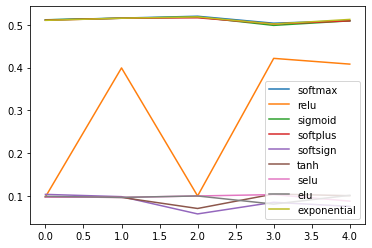

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

    
def test_activation(a): 
    print("--- "+a+" ---")
    def baseline_model():
        # Create model here
        model = keras.Sequential([
        layers.Dense(10, activation=a, input_shape=(13,)),
        ])
        # Compile model here
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        return model
    
    plt.plot(test_model(baseline_model), label=a)
    print("--------------------------")
    return


test_activation('softmax')
test_activation('relu')
test_activation('sigmoid')
test_activation('softplus')
test_activation('softsign')
test_activation('tanh')
test_activation('selu')
test_activation('elu')
test_activation('exponential')

plt.legend(loc='lower right')
plt.savefig('0_layer.png')
#plt.show()

We can easily see 'softmax', 'sigmoid' and 'softplus' are the winners here. 'Exponential' also performs well when setting epochs to a high enough value.  Between these 3 options results tend to vary slightly, so we will use softplus as it tends to be the fastest one no matter how many epochs are used, and it gives us the smallest standard deviation. As expected this one layer gives us a decent but not very accurate model. Let's go ahead and add some layers to our model.

--- 0 layer ---
Result: 51.24% (0.53%)
time elapsed: 20.787265300750732 seconds
--------------
--- 1 layer ---
Result: 56.22% (0.35%)
time elapsed: 24.93037700653076 seconds
---------------
--- 2 layers ---
Result: 57.97% (0.46%)
time elapsed: 29.216630220413208 seconds
----------------
--- 3 layers ---
Result: 58.15% (0.29%)
time elapsed: 33.58083391189575 seconds
----------------
--- 4 layers ---
Result: 58.22% (0.55%)
time elapsed: 38.01927947998047 seconds
----------------


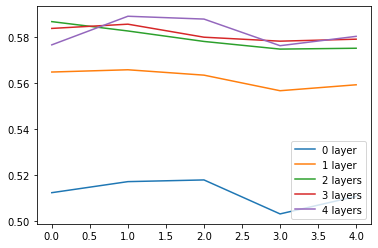

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

print("--- 0 layer ---")
def baseline_model():
    model = keras.Sequential([
    layers.Dense(10, activation='softplus', input_shape=(13,)),
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    
plt.plot(test_model(baseline_model), label='0 layer')
print("--------------")


print("--- 1 layer ---")
def baseline_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    
plt.plot(test_model(baseline_model), label='1 layer')
print("---------------")


print("--- 2 layers ---")
def baseline_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    
plt.plot(test_model(baseline_model), label='2 layers')
print("----------------")


print("--- 3 layers ---")
def baseline_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    
plt.plot(test_model(baseline_model), label='3 layers')
print("----------------")


print("--- 4 layers ---")
def baseline_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    
plt.plot(test_model(baseline_model), label='4 layers')
print("----------------")

plt.legend(loc='lower right')
plt.savefig('layers.png')
#plt.show()


It is clear that every added layer gives us a higher accuracy, but every layer also adds to the execution time. We also notice that the test accuracy for 3 layers is sometimes higher than for 4 layers, which means that the model seems to perform the best with only  layers, adding another layer increases execution time (by about 5 seconds) but does not guarantee an improved accuracy. Because of this we will continue with 3 layers. To try and improve our model further we will see what values for units per layer perform best.

--- 16 units ---
Result: 55.46% (0.45%)
time elapsed: 23.275831699371338 seconds
----------------
--- 32 units ---
Result: 57.14% (0.38%)
time elapsed: 29.5488440990448 seconds
----------------
--- 48 units ---
Result: 58.29% (0.15%)
time elapsed: 31.966670989990234 seconds
----------------
--- 64 units ---
Result: 58.25% (0.40%)
time elapsed: 33.511003494262695 seconds
----------------
--- 128 units ---
Result: 57.95% (0.56%)
time elapsed: 57.87493181228638 seconds
----------------
--- 256 units ---
Result: 55.43% (0.73%)
time elapsed: 104.24629378318787 seconds
----------------


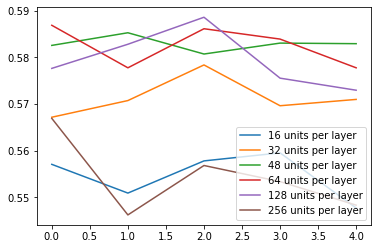

In [9]:
def test_units(units):
    print("--- "+str(units)+" units ---")
    def baseline_model():
        model = keras.Sequential([
        layers.Dense(units, activation='relu', input_shape=(13,)),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(10, activation='softplus')
        ])
        # Compile model here
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        return model
    
    plt.plot(test_model(baseline_model), label=str(units)+' units per layer')
    print("----------------")
    return

test_units(16)
test_units(32)
test_units(48)
test_units(64)
test_units(128)
test_units(256)
plt.legend(loc='lower right')
plt.savefig('units.png')
#plt.show()

We can see the higher the units per layer the higher the accuracy, up until about 64. For now we will keep the units per layer at 64 to preserve an acceptable execution time as well as avoid overfitting after 100 epochs.  We can try and improve our model even further by adding normalization layers to our model. 

--- No normalization ---
Result: 58.36% (0.47%)
time elapsed: 35.021299600601196 seconds
----------------
--- Batch normalization ---
Result: 57.76% (0.31%)
time elapsed: 60.13295531272888 seconds
----------------
--- Linear normalization ---
Result: 55.63% (0.40%)
time elapsed: 114.24008345603943 seconds
----------------


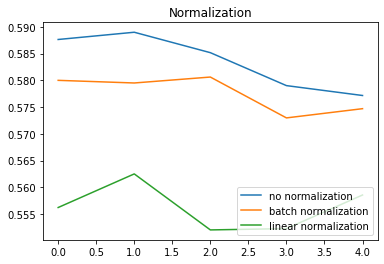

In [10]:
print("--- No normalization ---")
def baseline_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

plt.plot(test_model(baseline_model), label='no normalization')
print("----------------")



print("--- Batch normalization ---")
def baseline_model():
    model = keras.Sequential([
    layers.BatchNormalization(input_shape=(13,)),
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

plt.plot(test_model(baseline_model), label='batch normalization')
print("----------------")



print("--- Linear normalization ---")
def baseline_model():
    model = keras.Sequential([
    layers.LayerNormalization(axis=1, input_shape=(13,)),
    layers.Dense(64, activation='relu', input_shape=(13,)),
    layers.LayerNormalization(axis=1),
    layers.Dense(64, activation='relu'),
    layers.LayerNormalization(axis=1),
    layers.Dense(64, activation='relu'),
    layers.LayerNormalization(axis=1),
    layers.Dense(10, activation='softplus')
    ])
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

plt.plot(test_model(baseline_model), label='linear normalization')
print("----------------")


plt.title('Normalization')
plt.legend(loc='lower right')
plt.savefig('normalization.png')
#plt.show()
#output = test_usability_parameters(model)

Batch normalization improves our model slightly sometimes, but often makes it worse. Layer normalization makes our model worse. We will go ahead using no normalization as it does not appear to improve our model and the execution time doubled when applying batch normalization. Another thing we can try to improve our model is adding dropout.

--- dropout = 0 ---
Result: 58.38% (0.32%)
time elapsed: 52.52842307090759 seconds
----------------
--- dropout = 0.1 ---
Result: 58.73% (0.32%)
time elapsed: 52.401119232177734 seconds
----------------
--- dropout = 0.2 ---
Result: 58.18% (0.44%)
time elapsed: 52.387659549713135 seconds
----------------
--- dropout = 0.3 ---
Result: 57.23% (0.25%)
time elapsed: 52.046377658843994 seconds
----------------
--- dropout = 0.4 ---
Result: 56.22% (0.19%)
time elapsed: 53.0591242313385 seconds
----------------
--- dropout = 0.5 ---
Result: 54.41% (0.69%)
time elapsed: 51.49980974197388 seconds
----------------


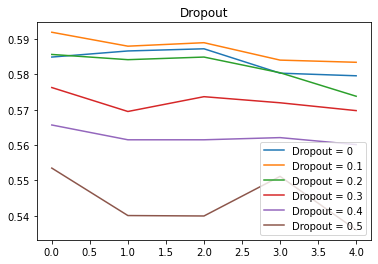

In [11]:
def test_dropout(dropout):
    print("--- dropout = "+str(dropout)+" ---")
    def baseline_model():
        model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(13,)),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(10, activation='softplus')
        ])
        # Compile model here
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        return model

    plt.plot(test_model(baseline_model), label='Dropout = '+str(dropout))
    print("----------------")
    return

test_dropout(0)
test_dropout(0.1)
test_dropout(0.2)
test_dropout(0.3)
test_dropout(0.4)
test_dropout(0.5)

plt.title('Dropout')
plt.legend(loc='lower right')
#plt.show()
plt.savefig('dropout.png')
#output = test_usability_parameters(model)

We can see that any amount of dropout quickly makes our model worse, except for 0.1.

# Conclusion
Once more we can tell that even by spending more time tweaking our model, we will never achieve a score above 0.7. This tells us that determining the genre of a song accurately based on the given features is not really feasible using simple classification models. Perhaps by removing the genre column and attempting clustering instead of classification might give us a better solution. Maybe there are other, more complex classification models that would have better luck at completing this task but for now this seems to be the best we can get.

In [12]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

1268/1268 [==============================] - 1s 903us/step - loss: 1.5519 - accuracy: 0.4083


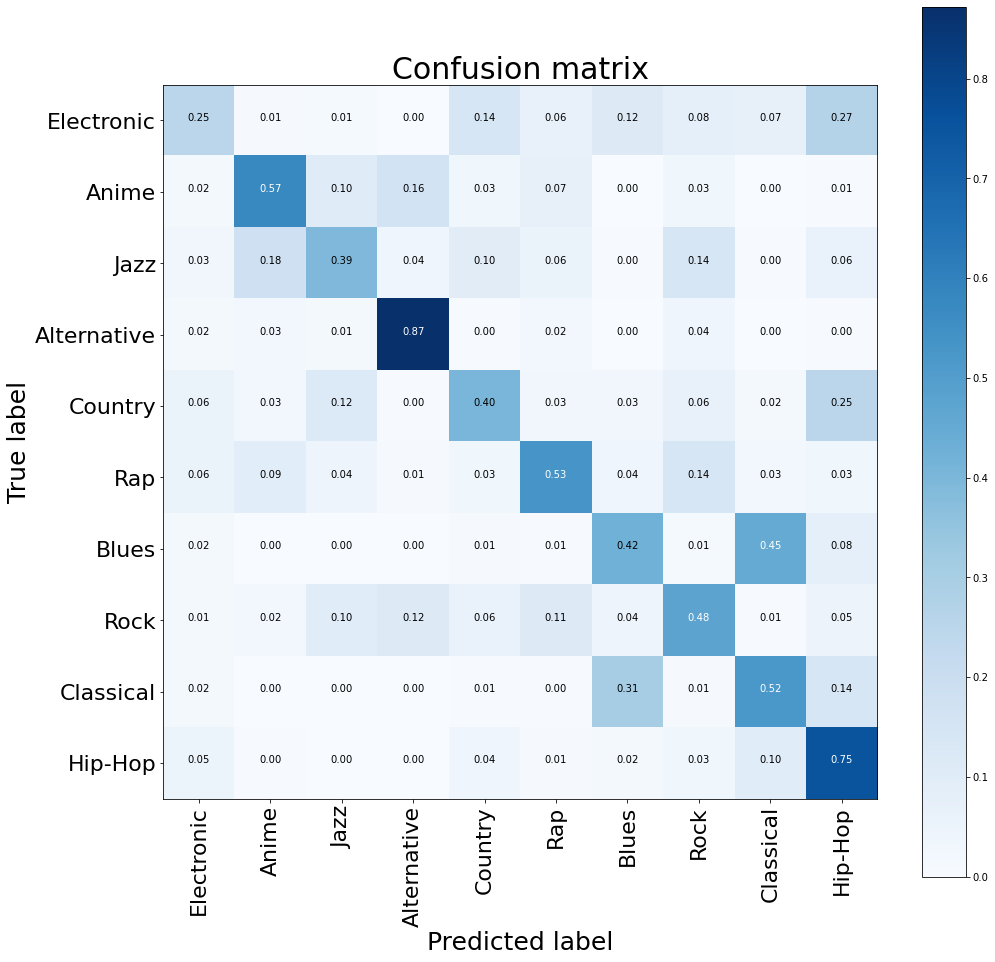

In [20]:
from sklearn.metrics import confusion_matrix

model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(13,)),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(10, activation='softplus')
        ])
# Compile model here
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X, Y)
y_pred = model.predict(X)

cnf_matrix = confusion_matrix(Y.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(16,16))
plot_confusion_matrix(cnf_matrix, classes=genre_encoder.inverse_transform(df2.music_genre.unique()), title="Confusion matrix")
plt.savefig('conf_matrix_Keras.png')